# Quantum Singular Value Transformation (QSVT) 

In this notebook we will explore the Quantum Singular Value Transformation (QSVT), a framework that unifies many prominent quantum algorithms. We mainly follow the paper [Grand Unification of Quantum Algorithms, by Martin et al.](https://arxiv.org/abs/2105.02859), which we recommend for more details. 


## Quantum Signal Processing


For pedagogical purposes, we would like to start the discussion of QSVT with Quantum Singular Processing (QSP). 

The QSP operation sequence is defined as follows:

$$	U_{\vec{\phi}} = e^{i\phi_{0}Z} \prod_{k=1}^{d} W(\alpha) e^{i\phi_{k}Z}, $$
where $W(\alpha)$ is an x-rotation by angle $\theta = -2\arcsin(\alpha)$:
			$$W(\alpha) = \begin{pmatrix}
				\alpha             &
				i\sqrt{1-\alpha^2}          \\
				i\sqrt{1-\alpha^2} & \alpha
			\end{pmatrix}$$

The importance of QSP, at least for our discussion, lies in the following theorem:

**QSP Theorem**: 

The QSP sequence $U_{\vec{\phi}}$ produces a matrix that may be expressed as a polynomial function of $\alpha$:
		
\begin{equation*}
			U_{\vec{\phi}} = \begin{pmatrix}
				P(\alpha)                   &
				iQ(\alpha)\sqrt{1-\alpha^2}               \\
				iQ^*(\alpha)\sqrt{1-\alpha^2} & P^*(\alpha)
			\end{pmatrix}
\end{equation*}
for $\alpha \in [-1,1]$, and a $\vec{\phi}$ exists for any polynomials $P,Q$ in $\alpha$ such that:
1. $\deg(P) \leq d$ and $\deg(Q) \leq d-1$
2. $P$ has parity $d\bmod2$ and $Q$ has parity
			      $(d-1) \bmod 2$
3. $|P|^2 + (1-\alpha^2) |Q|^2 = 1$

So, what this theorem tell us? First of all, applying the QSP sequence leads to a polynomial transformation of the matrix element $ \bra 0|U_{\vec{\phi}}\ket0 $. 
However, maybe most importantly, the inverse is also true! That is, for any given polynomial (subject to the conditions above), we can find a QSP sequence that realizes it. In the following, we will see how this simple idea can be used to implement many quantum algorithms.

It is important to notice here that the third condition is actually quite restrictive (check what happens when $\alpha=1$), but we can actually circumvent this condition. Without going into too much detail, we 
can essentially find a QSP sequence so that $Re(P(\alpha))$ gives the desired polynomial, with $|P(\alpha)|$ being bounded by $1$ (instead of being equal to $1$ in 
the boundary).



In the following we will implement two quantum circuits: The first one computes the Chebyshev polynomial of the first kind of a real number $a$, while with the second one we can realize the BB1 pulse sequence. 




In [43]:
# import libraries 
import numpy as np
import scipy 
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, execute, Aer
from qiskit.quantum_info import Pauli, Operator
from scipy.special import chebyt
from matplotlib import pyplot as plt
import pyqsp
from functools import reduce
from pyqsp import angle_sequence
from IPython.utils import io # this is for suppressing output from pyqsp

# plotting parameters
plt.rcParams['figure.figsize'] = [8, 4]
plt.rcParams.update({'font.size': 16})
plt.rcParams['legend.fontsize'] = 10
plt.rcParams['legend.handlelength'] = 2
plt.rcParams['axes.linewidth'] = 2
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)




In [30]:
# signal rotation operator 
def W(a): 
    '''
    Return the signal rotation operator
    Arguments: 
        a: the parameter of the signal rotation operator, i.e theta = -2acos(a)
    Returns: 
        W: numpy array with the signal rotation operator
    '''
    return np.array([[a, 1j*np.sqrt(1-a**2)], [1j*np.sqrt(1-a**2), a]])

# Quantum signal processing circuit
def create_QSP_circuit(a,phi):
    '''
    Create a QSP circuit with parameters a and phi. 
    Arguments: 
        a  : rotation angle of the signal rotation operator.
        phi: numpy array with the rotation phases
    Returns: 
        qc :  a quantum circuit which implements the QSP 
    '''
    q = QuantumRegister(1, '')
    qc = QuantumCircuit(q)
    # add the phi0 signal-processing rotation 
    qc.rz(phi[0],q)
    # add the QSP rotations
    for i in range(1,phi.size):
        qc.unitary(W(a),q, label='W')
        qc.rz(-2*phi[i],q)
    return qc


### Chebyshev polynomial with QSP 

Here, we calculate the Chebyshev polynomial of the first kind $T_N(a)$, for $\alpha \in [-1,1]$. This can be achieved using the QSP angles $\vec{\phi} = \vec{0} \in \mathbb{R}^{N+1}$. We should note that in a real quantum computer, we wouldn't have direct access to the calculated value, since it is encoded as a probability amplitude. 

Text(0, 0.5, '$T_{5}(\\alpha)$')

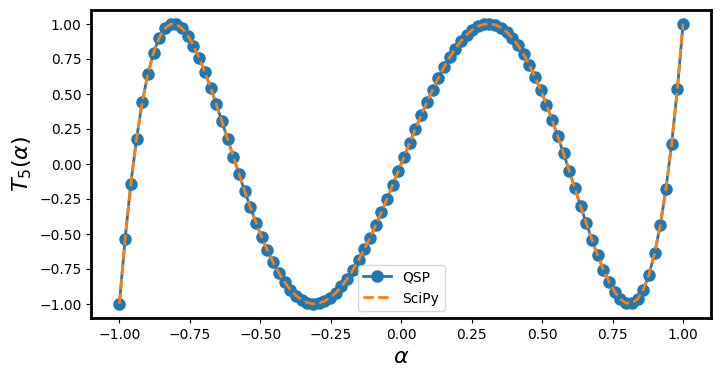

In [31]:
# create the backend, it will be used to run all the circuits
backend = Aer.get_backend('statevector_simulator')

# parameters of the QSP
N = 5 ; # order of the Chebyshev polynomial
phi = np.zeros(N+1) ; # rotation phases

x = np.linspace(-1,1,100)
chebyt_qsp = np.zeros(x.size)
chebyt_builtin = np.zeros(x.size)

for i in range(x.size):
    qc = create_QSP_circuit(x[i],phi)
    job = backend.run(qc)
    result = job.result()
    output_state = result.get_statevector(qc)
    calculated_chebyt = output_state.data[0]
    chebyt_qsp[i] = np.real(calculated_chebyt)
    chebyt_builtin[i] = chebyt(N)(x[i])

# plot the results
plt.plot(x,chebyt_qsp, label='QSP', marker = 'o', markersize = 8, linewidth=2)
plt.plot(x,chebyt_builtin, label='SciPy', linestyle='--', linewidth=2)
plt.legend()
plt.xlabel(r'$\alpha$')
plt.ylabel(r'$T_{%d}(\alpha)$'%N)

#plt.savefig('chebyt_qsp.png', dpi=300, bbox_inches='tight')

### BB1 Pulse

We want to reproduce the Figure 1 of [[1]](https://arxiv.org/abs/2105.02859), which shows the BB1 pulse sequence. This is defined as follows: 

$$ \vec{\phi} = (\pi/2,-\eta,2\eta,0,-2\eta,\eta),$$
where $\eta = \frac{1}{2} \arccos(-1/4)$. This sequence is of particular importance in the field of NMR. Here, we want to test that our implementation of QSP is actually 
correct. Indeed, there is total agreement between the results of our implementation and the results of the paper. 

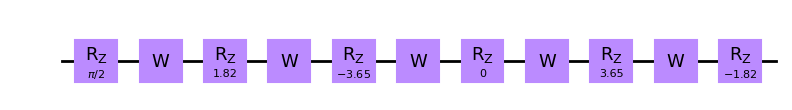

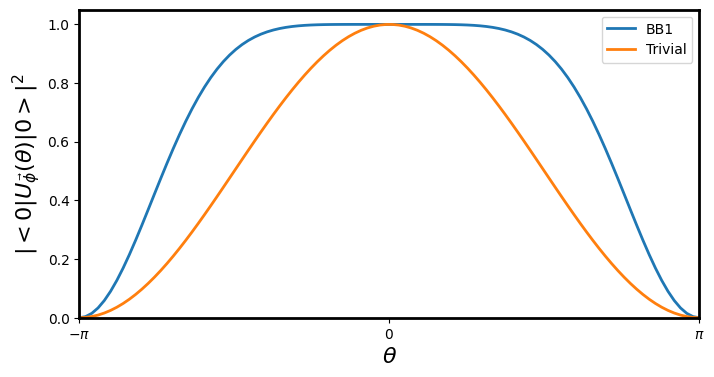

In [33]:
eta = 1/2 * np.arccos(-1/4)
phi = np.array([np.pi/2,-eta, 2*eta,0,-2*eta,eta])
theta = np.linspace(-np.pi,np.pi,100)
p = np.zeros(theta.size)
s = np.zeros(theta.size)

for i in range(theta.size):
    qc = create_QSP_circuit(np.cos(-theta[i]/2),phi)
    job = backend.run(qc)
    result = job.result()
    output_state = result.get_statevector(qc)
    p[i]= np.abs(output_state.data[0])**2
    qc = create_QSP_circuit(np.cos(-theta[i]/2),np.array([0,0]))
    job = backend.run(qc)
    result = job.result()
    output_state = result.get_statevector(qc)
    s[i]= np.abs(output_state.data[0])**2

# plot the probability with respect to theta
#p_theoretical = 1/8 * np.cos(theta/2)**2 *[3*np.cos(theta/2)**8 - 15*np.cos(theta/2)**6 + 35*np.cos(theta/2)**4 - 45*np.cos(theta/2)**2 + 30]
plt.plot(theta,p, label = r'BB1', linewidth = 2)
plt.plot(theta,s, label = r'Trivial', linewidth = 2)
plt.legend()

# set xticks 
plt.xticks([-np.pi,0,np.pi],[r'$-\pi$',r'$0$',r'$\pi$'])
plt.xlabel(r'$\theta$')
plt.ylabel(r'$|<0|U_\vec{\phi}(\theta)|0>|^2$')
# set xlim
plt.xlim([-np.pi,np.pi])
plt.ylim([0,1.05])
#plt.rcParams['figure.figsize'] = [16, 8]
#plt.savefig('p_theta.png', dpi=300, bbox_inches='tight')

# create the circuit
qc = create_QSP_circuit(np.cos(-theta[0]/2),phi)
# draw the circuit
qc.draw(output='mpl', scale = 1.0)


## Quantum Singular Value Transformation (QSVT) 

In the QSP section, we saw how a sequence of gates can be used to implement a polynomial transformation of a matrix element. In essence, we applied a polynomial transformation to the top left corner of the matrix $W(\alpha)$. In QSVT, we want to go one step further: Apply a polynomial transformation not to a scalar value, but to a matrix itself. This is the basic idea of QSVT. However, in order to reach this goal, we need to introduce some more concepts, which are the building blocks of QSVT.

### Block encoding

Since we want to apply a transformation to the "top left corner" of a unitary matrix, we have to make this concept clear. We say that a matrix $A$ is block encoded by a unitary matrix, if the unitary $U$ has the following form:

$$ U = \begin{pmatrix*}
				A                   &
				.               \\
				. & .
			\end{pmatrix*}$$
			
Here, we don't assume anything about the dimension of the matrix $A$, i.e it can also be a rectangular matrix. The above definition implies that there exist two projectors $\tilde{\Pi}$ and $\Pi$, such that: 
$$ A = \tilde{\Pi} U \Pi.$$
These are the projectors that locate $A$ within the unitary matrix $U$. In general, $\tilde{\Pi}$ projects to the right singular space of $A$, while $\Pi$ projects to the left singular space of $A$.

A natural question is: Can we block encode any matrix? The answer is no. Since we want the full matrix to be unitary, it is clear that a matrix $A$ with spectral norm greater than $1$ cannot be block encoded. However, in practice, we can always divide such a matrix with a scalar, so that the resulting matrix has spectral norm less than $1$. 
### Projector controlled phase shift
As we will see, of particular importance in QSVT is the projector controlled phase shift operation $\Pi_{\phi} := e^{i2\phi \Pi}$, where $\Pi$ is a projector. This operator imparts a phase of $e^{i2\phi}$ to the image of the projector $\Pi$. We can realize this operator using the following circuit:

![./figures/cpnot.png](./figures/cpnot.png)


In this circuit, the first qubit is an ancilla qubit, and the first gate is the so-called projector-controlled-not gate, which we denote as $C_{\Pi}NOT$. For 
the implementation of this gate, we used the fact that $C_{\Pi}NOT = X \otimes \Pi + I \otimes (I-\Pi)$. 


### QSVT Theorem
Having introduced the above concepts, we can now shortly describe the QSVT theorem. 

Let $A = \sum_{k}\sigma_{k}\ket{w_{k}}\bra{v_{k}}$ be a matrix, which is *block-encoded* in a unitary $U$:
\begin{equation*}
	U = \begin{pmatrix*}
		A & \bullet \\
		\bullet & \bullet
	\end{pmatrix*}
\end{equation*}
Then, for odd $d$ we have that:
\begin{equation*}
	U_{\vec{\phi}} = \tilde{\Pi}_{\phi_1} U \left(\prod_{k=1}^{(d-1)/2} \Pi_{\phi_{2k}} U^\dagger \tilde{\Pi}_{\phi_{2k+1}} U \right)= \begin{pmatrix*}
		Poly(A) & \bullet \\
		\bullet        & \bullet
	\end{pmatrix*}
\end{equation*}
where $Poly(A) = \sum_{k} Poly(\sigma_{k}) \ket{w_{k}}\bra{v_{k}}$ is a *polynomial transform* of the singular values.

Similar formula holds for even $d$, but with the crucial modification that the input and the output space are both the right singular space. 


## Quantum Search with QSVT

All the things we have seen so far seem quite abstract. However, we will now see how these ideas can be used to implement the Quantum Search algorithm, i.e 
finding a marked item in an unstructured database. 

Assume an oracle $U$, such that $U\ket{j} =
(-1)^{\delta_{jm}}\ket{j}$. Assume also that our initial state $\ket{\psi_{0}}$
is the uniform superposition:
\begin{equation*}
\ket{\psi_{0}} = \frac{1}{N} \sum_{j}^{N}\ket{j} =
\sqrt{\frac{N-1}{N}}\ket{m^{\perp}} + \sqrt{\frac{1}{N}} \ket{m}
\end{equation*}
Our ultimate goal is to map the initial state $\ket{\psi_{0}}$ to the state $\ket{m}$, 
which is the state that contains the marked item.

The condition that the initial state $\ket{\psi_{0}}$ has a
non-zero projection on the marked state $\ket{m}$, is equivalent to $\Pi V
\ket{\psi_{0}} = \alpha \ket{m}$, with
$\Pi := \ket{m}\bra{m}$ and $\alpha = \sqrt{\frac{1}{N}}$. In our case,
$V$ is the identity.
Denoting $\Pi^{\prime} := \ket{\psi_{0}}\bra{\psi_{0}}$, the
above condition becomes:
\begin{equation*}
\Pi V \Pi^{\prime} = \Pi \Pi^{\prime} = \alpha \ket{m}
\bra{\psi_{0}}
\end{equation*}

Does this equation look familiar? This is the block-encoding of a single singular value $\alpha$ in the unitary $V$. 

What we managed to do, is to express the problem in the language of QSVT. The next step is to find an appropriate polynomial $P$, which realizes the desired transformation. 

Ideally, we would like to apply the sign function to the singular value $\alpha$. So, a natural next step is to find a polynomial approximation of the sign function. 
Without getting into the details, this is actually possible [[1]](https://arxiv.org/abs/2105.02859), by using the fact that the sign function is well approximated by the 
well-known error function. In our implementation, we use the python library [pyqsp](https://github.com/ichuang/pyqsp), which calculates the respective polynomial for us.
The complexity of the algorithm is given by the degree of the polynomial, and it turns out that we get the same complexity as the original Grover algorithm, i.e $O(\sqrt{N})$, but without convergence issues. 

**Note 1 :** In the original form of the algorithm, we need to do a projection using the unknown state $\ket{m}$. While this is the state we are actually looking for, we
can achieve this projection using the oracle. In our implementation, we didn't use the oracle, but we just randomly picked a state $\ket{m}$, assuming that this is the state we are looking for. This was done only for simplicity reasons, and it doesn't affect the correctness of the algorithm. Incorportating the oracle is straightforward, but we didn't want to clutter the code, since it is not essential for the algorithm.

**Note 2 :** The way we described the algorithm above, we assumed that $V$ is the identity matrix and the initial state is the uniform superposition. Equivalently, 
we could have assumed that $V = H^{\otimes n}$ and the initial state is the zero state. That's what we did in our implementation.



In [39]:
# These gates were imported for testing purposes only
from qiskit.quantum_info import partial_trace
from qiskit.circuit.library import GlobalPhaseGate

def p_controlled_phase_shift(P, phi):
    '''
    Return the projector-controlled phase shift operator. 
    Arguments:
        P  : the projector
        phi: the rotation angle
    Returns:
        U  : numpy array with the projector-controlled phase shift operator
    Note: This is for debugging purposes only. For an implementation closer to the paper, see projector_controlled_phase_shift.
    '''
    N = len(P)
    return np.eye(N)*np.cos(phi)+1j*(2*P-np.eye(N))*np.sin(phi)

def projector_controlled_phase_shift(P, phi, num_qubits, kind): 
    '''
    Quantum circuit realizing the projector-controlled phase shift operator, as described in the paper.
    Arguments:
        P  : the projector
        phi: the rotation angle
        num_qubits: the number of qubits
        kind: 'left' or 'right', depending on whether the projector is the left or the right projector. 
               It is used only for nice printing of the circuit.
    Returns:
        qc : a quantum circuit realizing the projector-controlled phase shift operator
    '''

    # This is only for nice printing of the circuit, with notation compatible with the paper
    if kind == 'left': 
        label = r'$C_{\widetilde{\Pi}}NOT$'
    elif kind == 'right':
        label = r'$C_{\Pi}NOT$'
    else:
        label = r'$A$' # some arbitrary label
        

    # Create the quantum circuit
    q = QuantumRegister(num_qubits+1)
    qc = QuantumCircuit(q)
    qc.barrier()

    # Define the operator 
    projector = Operator(P)
    X = Operator.to_operator(Pauli('X'))
    I_n = Operator.to_operator(Pauli('I'*num_qubits))
    I = Operator.to_operator(Pauli('I'))
    projector_controlled_not = (projector^X) + ((I_n - projector)^I)
    
    # create the circuit
    qc.unitary(projector_controlled_not, q, label = label)
    qc.rz(2*phi, q[0])
    qc.unitary(projector_controlled_not, q, label = label)
    qc.barrier()
    
    return qc

def create_qsvt_circuit(U,PL,PR, phi, num_qubits):

    '''
    Create a QSVT circuit with parameters U, PL, PR and phi. 
    Arguments: 
        U  : the unitary operator, which block encodes the matrix of interest
        PL : the left projector
        PR : the right projector
        phi: numpy array with the rotation phases
    Returns: 
        qc :  a quantum circuit which implements the QSVT 
    '''
    # create the quantum circuit
    q = QuantumRegister(num_qubits+1) # the first qubit is the ancilla
    qc = QuantumCircuit(q)

    N = len(phi)
    d = N - 1
    if len(phi)%2 != 0:
        # if the number of phases is odd, then the polynomial is of even degree, Pr = Pi and Pl = Pi_tilde
        qc.compose(projector_controlled_phase_shift(PR,phi[-1], num_qubits,kind = 'right'), inplace = True)
        for i in reversed(range((d//2))):
            # apply the unitary operator to all but the ancilla qubit
            qc.unitary(U,q[1:], label = (r'U'))
            qc.compose(projector_controlled_phase_shift(PL,phi[2*i+1], num_qubits, kind = 'left'), inplace = True)
            qc.unitary(U.T.conj(),q[1:], label = (r'U$^\dagger$'))
            qc.compose(projector_controlled_phase_shift(PR,phi[2*i], num_qubits, kind = 'right'), inplace = True)
    else:
        # if the number of phases is even, then the polynomial is of odd degree
        #qc.unitary(p_controlled_phase_shift(PR,phi[d]),q[1:], label = (r'${\Pi}_{' + str(d)) + '}$') 
        qc.compose(projector_controlled_phase_shift(PR,phi[d], num_qubits, kind = 'right'), inplace = True)
        for i in reversed(range(1, (d-1)//2+1)):
            qc.unitary(U,q[1:], label = (r'U'))     
            #qc.unitary(p_controlled_phase_shift(PL,phi[2*i]),q[1:], label = (r'$\widetilde{\Pi}_{' + str(2*i)) + '}$')
            qc.compose(projector_controlled_phase_shift(PL,phi[2*i], num_qubits, kind = 'left'), inplace = True)
            qc.unitary(U.T.conj(),q[1:], label = (r'U$^\dagger$'))
            #qc.unitary(p_controlled_phase_shift(PR,phi[2*i-1]),q[1:], label = (r'${\Pi}_{' + str(2*i-1)) + '}$')
            qc.compose(projector_controlled_phase_shift(PR,phi[2*i-1], num_qubits, kind ='right'), inplace = True)
        qc.unitary(U,q[1:], label = (r'U'))
        #qc.unitary(p_controlled_phase_shift(PL,phi[0]),q[1:], label = (r'$\widetilde{\Pi}_{' + str(0)) + '}$')
        qc.compose(projector_controlled_phase_shift(PL,phi[0], num_qubits, kind = 'left'), inplace = True)
    return qc

def angles_from_W_to_R(phis):
    """Converts QSP angles from W-convention to R-convention.
    Arguments:
        phis: numpy array with the QSP angles in W-convention
    Returns:
        phis: numpy array with the QSP angles in R-convention
    """
    # see page 27 of grand unification paper
    phis = [phis[0]+(2*(len(phis)-1)-1)*np.pi/4] + [phi-np.pi/2 for phi in phis[1:-1]] + [phis[-1]-np.pi/4]
    return phis 

def sign_approximating_polynomial(num_qubits):
    """Polynomial that approximates the step function theta(x) for x>= 1/N**0.5
    Arguments:
        num_qubits: number of qubits
    Returns:
        p: the desired polynomial
    """
    
    N = 2**num_qubits
    target_function = pyqsp.poly.PolySign()
    # we take the closest odd number to N**0.5. 
    degree = np.ceil(N**0.5) 
    if degree % 2 == 0:
        degree += 1
    print('degree = ', degree)
    # this is essentially the inverse of Delta from the paper
    Delta = N**0.5
    
    # Find the polynomial approximation.
    p = target_function.generate(degree, delta=Delta)
    
    return p

### Illustration of the QSVT circuit

We create a simple example of a qsvt circuit, with random parameters, and we draw it. The barriers are used to separate the different parts of the circuit, i.e $\Pi_{\phi}$, $U$, $\tilde{\Pi}_{\phi}$ and $U^\dagger$. The top qubit represents the ancilla qubit, which is necessary to realize the projector controlled phase shift. 

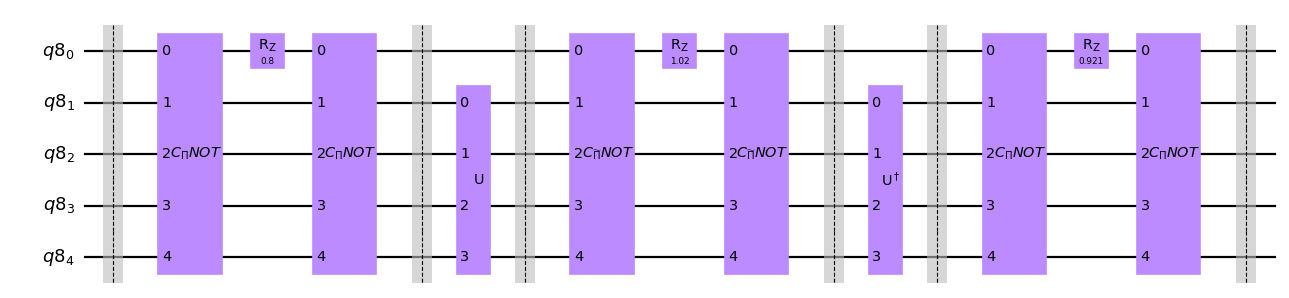

In [40]:
# create QSVT circuit, just for visualization purposes
q = 4
U = np.eye(2**q)
v = np.zeros(2**q) ; v[0] = 1
P = np.outer(v,v.conj())
phi = np.random.rand(3)
qsvt_circuit = create_qsvt_circuit(U,P,P, phi, q)
# draw the circuit
qsvt_circuit.draw(output = 'mpl', scale = 0.8)

### Polynomial approximation

We show some approximations of the sign function using polynomials of different degrees. We can see that the approximation gets better as the degree of the polynomial increases.

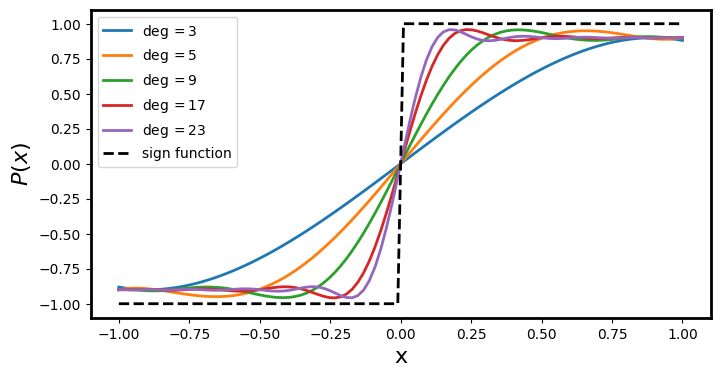

In [45]:
# check the polynomial approximation for different values of qubits 
N = [2,4,6,8,9]
degrees = [np.ceil((2**n)**0.5) if np.ceil((2**n)**0.5)%2 == 1 else np.ceil((2**n)**0.5)+1 for n in N]
for i,n in enumerate(N):
    with io.capture_output() as captured:
        p = sign_approximating_polynomial(n)    
    x = np.linspace(-1,1,100)
    plt.plot(x,p(x), label = r'$\deg = %d$'%degrees[i], linewidth = 2)

# plot the sign function
plt.plot(x,np.sign(x), label = 'sign function', linewidth = 2, linestyle = '--', color = 'black')
plt.xlabel('x')
plt.ylabel(r'$P(x)$')
plt.legend()

#plt.savefig('sign_approximation.png', dpi=300, bbox_inches='tight')



## Grover - Numerical experiment

In [52]:
np.random.seed(1)

num_qubits = np.array([2,4,6,8,9]) # number of qubits

original_amplitudes = [1/np.sqrt(2**qubits) for qubits in num_qubits] # probability amplitudes, before QSVT

with io.capture_output() as captured: # suppress the output of pyqsp
    values_poly = [sign_approximating_polynomial(qubits)(2**(-0.5*qubits)) for qubits in num_qubits] # values of the approximating polynomial

amplitudes = np.zeros(num_qubits.size) # probability amplitudes, after QSVT
for i,qubits in enumerate(num_qubits):
    
    # U is the unitary operator which we block encode. It is just the Hadamard gate applied to all qubits
    H = 1/np.sqrt(2)*np.array([[1,1],[1,-1]])
    U = reduce(np.kron, [H]*qubits)

    # define the right projector
    all_zero_state = np.zeros(2**qubits) ; all_zero_state[0] = 1
    PR = np.outer(all_zero_state,all_zero_state.conj())

    # define the left projector - we choose it randomly. In a real application, we would have indirect access to it, through the oracle
    r = np.random.randint(0,2**qubits)
    m = np.zeros(2**qubits) ; m[r] = 1
    PL = np.outer(m,m.conj())

    # Estimate the phases, suppressing the output of pyqsp
    with io.capture_output() as captured:
        p = sign_approximating_polynomial(qubits)
        phi = pyqsp.angle_sequence.QuantumSignalProcessingPhases(p.coef, signal_operator='Wx')

    # convert the phases from W-convention to R-convention
    phi = angles_from_W_to_R(phi)

    # create the QSVT circuit
    backend = Aer.get_backend('statevector_simulator')
    qsvt_circuit = create_qsvt_circuit(U,PL,PR, phi, qubits)

    # run the circuit and get the output statevector
    job = backend.run(qsvt_circuit)
    result = job.result()
    output_state = np.array(result.get_statevector(qsvt_circuit))

    # find the probability of measuring the |m> state
    amplitudes[i] =  output_state[2*r].real


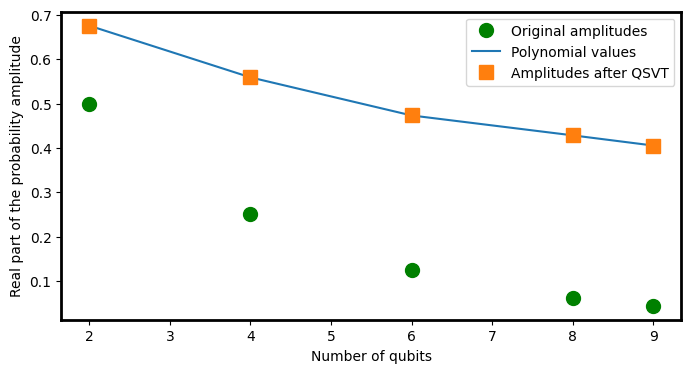

In [53]:
# plot the results
plt.plot(num_qubits,original_amplitudes, label = 'Original amplitudes ', marker = 'o', markersize = 10, linestyle = 'None', color = 'green')
plt.plot(num_qubits,values_poly, label = 'Polynomial values', markersize = 10)
plt.plot(num_qubits,amplitudes, label = 'Amplitudes after QSVT', marker = 's', markersize = 10, linestyle = 'None')
plt.xlabel('Number of qubits', fontsize = 10)
plt.ylabel('Real part of the probability amplitude', fontsize = 10)
plt.legend()
#plt.savefig('quantum_search_final.png', dpi=300, bbox_inches='tight')


## Solving Linear Systems of Equations

Our next goal is to solve linear systems of equations using QSVT, or more generally, to find the (pseudo)inverse of a matrix. Intuitively speaking, this is an application 
of the QSVT which is more obvious, in comparison to the search algorithm. Calculating the inverse is essentially a function evaluation problem, or roughly speaking, it's just an application of the function $f(x) = 1/x$ to the matrix of interest.

Similarly to the HHL algorithm, we assume that the singular values $\sigma_{i}$ of the matrix $A$ obey $\sigma_{i} \in [1/\kappa,1]$, where $\kappa$ is the condition number of the matrix.

Now, suppose that $A = W \Sigma V^{\dagger}$ is the singular value decomposition of $A$. Then, the inverse of $A$ is given by:
\begin{equation*}
A^{-1} = V \Sigma^{-1} W^{\dagger}
\end{equation*}

Since $A^\dagger = V \Sigma^{\dagger} W^{\dagger}$, we can express the inverse as $A^{-1} = f^{(SV)}(A^\dagger)$, where $f(x) = 1/x$. 

Now that we formulated the problem in the language of QSVT, we have to find an (odd) polynomial $P$ that approximates $f$ in the range of singular values. Actually, it turns out that it's better to approximate the function $g = \frac{1}{2\kappa x}$, and multiply the final result by $2\kappa$. The most important reason for this is that the function $g$ is bounded by $1$ by construction, which is not the case for $f$. 

As in the case of the search algorithm, we can actually find such a polynomial, with degree $d = O(\kappa \log(\kappa/\epsilon))$, where $\epsilon$ controls the accuracy of the approximation. For the implementation, we construct the polynomial using pyqsp, as before.  

### Implementation details 
There are various implementation details we would like to address here: 

1. The block-encoding is done using the formula: 
$$ U = \begin{pmatrix*}
A & \sqrt{1 - A A^\dagger} \\
\sqrt{1 - A^\dagger A} & -A^\dagger
\end{pmatrix*} $$
It is easy to verify that this matrix is unitary. If $A$ is not a square matrix of size $n = 2^k$, we pad with zeros, as needed.

2. We use a routine which randomly generates a matrix $A$, to find its inverse. We give as input, among else, the number of qubits $n$ and the condition number $\kappa$, and we get a matrix of random size, compatible with the number of qubits (rows and columns are less than $2^n$), fullfilling the necessary conditions for its singular values.

3. In our numerical experiment, we calculate the pseudo-inverse of a rectangular matrix $A$ and we solve a linear system of equations for a square matrix $A^\prime$ and a random right hand side $b$. We compare with the numpy implementation, and we get the same results.






### Utility Functions

In [67]:
def block_encode(A):
    """Block-encodes a matrix A into a unitary U.
    Args:
        A: The matrix to block-encode. We assume that the operator norm of A is <= 1.
    Returns:
        A unitary U such that U|0> = |A>.
    """
    A = pad_matrix(A)
    n,m = A.shape

    block_encoding = np.empty((n+m,n+m), dtype=complex)
    # upper left block
    block_encoding[:n,:m] = A
    # lower right block
    block_encoding[n:,m:] = -A.conj().T
    
    # do an SVD to get the other two blocks
    U,s,V = np.linalg.svd(A, full_matrices=True)

    # assert that the singular values are <= 1
    assert np.all(s <= 1), "The operator norm of A is larger than 1."
    

    # pad the singular values with zeros, depending on the size of A
    if n >= m:
        s1 = np.concatenate((s, np.zeros(n-m)))
        s2 = s 
    else:
        s1 = s
        s2 = np.concatenate((s, np.zeros(m-n)))
     
    # upper block
    upper_right_block = U @ np.diag(np.sqrt(1-s1**2)) @ U.conj().T
    block_encoding[:n,m:] = upper_right_block

    # lower left block
    lower_left_block = V.conj().T @ np.diag(np.sqrt(1-s2**2)) @ V
    block_encoding[n:,:m] = lower_left_block

    # padding with zeros to be a power of 2
    return block_encoding
    
# This was the first attempt for padding, but it is not a good idea     
""" 
def pad_matrix(A): 
    Returns a matrix that pads A with zeros to be a power of 2.
    Args:
        A: The matrix to pad.
    Returns:
        A matrix with zeros padded to A.
    n,m = A.shape
    N = int(2**np.ceil(np.log2(max(n,m))))
    padded_matrix = np.zeros((N,N), dtype=complex)
    padded_matrix[:n,:m] = A

    # the matrix C on the lower right corner, should be such that C@C_{dagger} = I
    C = np.zeros((N-n,N-m), dtype=complex)
    if n>m:
        C[:,:n-m] = np.eye(n-m)
    elif n<m:
        C[:m-n,:] = np.eye(m-n)
    else:
        C = np.eye(N-n)
    padded_matrix[n:,m:] = C
    return padded_matrix
 """

def pad_matrix(A):
    """Returns a matrix that pads A with zeros to be a power of 2.
    Args:
        A: The matrix to pad.
    Returns:
        A matrix with zeros padded to A.
    """
    n,m = A.shape
    N = int(2**np.ceil(np.log2(max(n,m))))
    padded_matrix = np.zeros((N,N), dtype=complex)
    padded_matrix[:n,:m] = A
    return padded_matrix


def xinverse_approximating_polynomial(kappa, epsilon):
    """Polynomal approxiamtion to 1/(2*kappa*x)"""
    
    target_function = pyqsp.poly.PolyOneOverX()
    coeffs, scale = target_function.generate(kappa=kappa, epsilon=epsilon, return_scale=True)
    
    # For some reason, pyqsp returns 1/x*scale with some `scale`
    # that might be different from 1/kappa. 
    # We remove this scale from our polynomial.
    
    return np.polynomial.Polynomial(coeffs/(scale*2*kappa))

def random_A(kappa, num_qubits, seed, square = True):
    """Construnct a random real operator A with ||A||<1 and condition number <= kappa.
        Size of A is n by m, which a both smaller than 2**num_qubits."""

    N = 2**num_qubits

    np.random.seed(seed) # set the seed of the random number generator
    n = np.random.randint(N//2+1, N+1) # for example if num_quibts = 2, then it is either 3 or 4
    
    if square:
        m = n 
    else:
        m = np.random.randint(N//2, N)

    V = scipy.stats.ortho_group.rvs(n, random_state=seed**2)
    W = scipy.stats.ortho_group.rvs(m, random_state=seed**3)

    singular_values = np.random.uniform(low=1/kappa, high=1, size=min(n, m)) 
    Sigma = np.zeros((n, m), dtype=complex)
    Sigma[:min(n, m), :min(n, m)] = np.diag(singular_values)

    A = V @ Sigma @ W.conj().T
    
    
    return A

def check_block_encoding(A, U):
    """Checks if a matrix A is unitary.
    Args:
        A: The matrix to check.
    Returns:
        True if A is unitary, False otherwise.
    """
    n,m = A.shape
        
    is_unitary = np.allclose(np.eye(len(U)), U@U.conj().T)
    is_block_encoding = np.allclose(U[:n,:m], A)

    return is_unitary and is_block_encoding

## Numerical Example - Finding the pseudoinverse

In [113]:
# create a random matrix A and block encode it
seed = 1
def find_inverse(kappa, epsilon, num_qubits, square = True):
    '''
    Find the inverse of a matrix random matrix A, using QSVT.
    Arguments:
        kappa: the condition number of the matrix A
        epsilon: the error of the approximation
        num_qubits: the number of qubits. A will be a matrix of size n by m, where n,m <= 2**num_qubits. 
        seed: the seed of the random number generator
        square: if True, then A will be a square matrix. 
    Returns:
        Ainv: the inverse of A, calculated using numpy
        Ainv_qsvt: the inverse of A, calculated using QSVT
        error: the operator norm of the difference between the two matrices
    '''
    A = random_A(kappa = kappa, num_qubits = num_qubits, seed = seed, square = square)
    U = block_encode(A.conj().T)
    n = U.shape[0]//2 # the size of the matrix A
    
    # check that U is unitary 
    if check_block_encoding(A.conj().T, U):
        print('The block encoding is successful.')
    else:
        print('The block encoding is not successful.')

    # define the projector 
    P = np.diag(np.concatenate((np.ones(n), np.zeros(n))))

    with io.capture_output() as captured: # suppress the output of pyqsp
        p = xinverse_approximating_polynomial(kappa, epsilon)
        phi = pyqsp.angle_sequence.QuantumSignalProcessingPhases(p.coef, signal_operator='Wx')
        phi = angles_from_W_to_R(phi)

    # create the QSVT circuit
    #backend = Aer.get_backend('statevector_simulator')
    backend = Aer.get_backend('unitary_simulator')
    qsvt_circuit = create_qsvt_circuit(U,P,P, phi, num_qubits+1) # one more qubit, since we block encode
    job = backend.run(qsvt_circuit)
    result = job.result()
    circuit_matrix = np.array(result.get_unitary(qsvt_circuit))
    circuit_matrix = circuit_matrix[::2,::2] # throwing the ancilla qubit, which is in the |0> state

    # find the inverse of A
    Ainv_qsvt = 2*kappa * np.real(circuit_matrix[:n,:n])
    # solve numerically the linear system Ax = b
    Ainv = np.linalg.pinv(A)
    n,m = A.T.shape
    error = np.linalg.norm(Ainv_qsvt[:n,:m]-Ainv.real, ord = 2)
    
    return A,Ainv.real, Ainv_qsvt[:n,:m].real, error

# solve the linear system
kappa = 3; epsilon = 0.1 ; num_qubits = 2 
A,Ainv, Ainv_qsvt, error = find_inverse(kappa = 3, epsilon = 0.1, num_qubits = 2, square = False)

# print the results
print('The matrix A is:\n', A.real)
print('A inverse from QSVT:\n', Ainv_qsvt)
print('A inverse from numpy:\n', Ainv)
print('The operator norm of the difference between the two matrices is: \n', error)




The block encoding is successful.
The matrix A is:
 [[ 0.46771328 -0.37012329 -0.28647424]
 [-0.42116718 -0.24033861 -0.20581365]
 [-0.23620005  0.1762832  -0.23033485]
 [-0.36641257  0.02882361  0.26230342]]
A inverse from QSVT:
 [[ 0.49498554 -1.0882023  -0.35345737 -0.61802373]
 [-1.12317512 -1.34017261  1.53376235 -0.87707429]
 [-0.43048594 -0.56901502 -1.80554201  1.26443666]]
A inverse from numpy:
 [[ 0.49368527 -1.09007429 -0.34797826 -0.62170586]
 [-1.13572127 -1.35742663  1.58662014 -0.91221802]
 [-0.42007946 -0.55474009 -1.84987312  1.29390131]]
The operator norm of the difference between the two matrices is: 
 0.08762622531003822


## Solving a linear system of equations

In [114]:
# define a square matrix A
num_qubits = 2 # we will use 2 qubits to encode the matrix A, so the matrix will be either 3x3 or 4x4 
kappa = 2 ; epsilon = 0.1 ; seed = 1 ; 
A = random_A(kappa = kappa, num_qubits = num_qubits, seed = seed, square = True)
U = block_encode(A.conj().T)

# create a random normalized right-hand side, using predefined seed for reproducibility
np.random.seed(seed)
n = A.shape[0] # number of unknowns
b = np.random.rand(n)
# we normalize it to encode it in the circuit
b = b/np.linalg.norm(b)

# create the initial state of the circuit
psi0 = np.zeros(2**(num_qubits+2)) # one for the ancilla, one for the block encoding
psi0[0:2*n:2] = b

P = np.diag(np.concatenate((np.ones(n), np.zeros(n))))

with io.capture_output() as captured: # suppress the output of pyqsp
    p = xinverse_approximating_polynomial(kappa, epsilon)
    phi = pyqsp.angle_sequence.QuantumSignalProcessingPhases(p.coef, signal_operator='Wx')
    phi = angles_from_W_to_R(phi)

# create a qsvt circuit 
qsvt_circuit = create_qsvt_circuit(U,P,P, phi, num_qubits+1) # one more qubit, since we block encode

# create another circuit to initialize in state |b>
q = QuantumRegister(num_qubits+2)
qc = QuantumCircuit(q)
qc.initialize(psi0,q)
n
# compose the two circuits
qc.compose(qsvt_circuit, inplace = True)
# run the circuit
backend = Aer.get_backend('statevector_simulator')
job = backend.run(qc)
result = job.result()
output_state = result.get_statevector(qc)
# find the solution
x_qsvt = np.array(output_state)[::2][:n].real
# normalize it
x_qsvt = x_qsvt/np.linalg.norm(x_qsvt)
# solving the dagger problem 
x_numpy = np.linalg.solve(A,b)
x_numpy = x_numpy/np.linalg.norm(x_numpy)
# print the solutions and compare them
print('matrix A is:')
print(A.real)
print('right hand side:')
print(b)
print('Solution from QSVT:')
print(x_qsvt)
print('Solution from numpy')
print(x_numpy.real)

# find the error
error = np.linalg.norm(x_qsvt-x_numpy.real)
print('The norm of the difference between the two solutions is: ', error)




matrix A is:
[[ 0.93557608 -0.14390618 -0.04735912  0.00996208]
 [-0.14390618  0.67087064 -0.11341952  0.02482602]
 [-0.04735912 -0.11341952  0.93454652  0.02449725]
 [ 0.00996208  0.02482602  0.02449725  0.98746033]]
right hand side:
[4.70924371e-01 8.13430360e-01 1.29158386e-04 3.41410705e-01]
Solution from QSVT:
[0.45097591 0.8639175  0.12009278 0.18932777]
Solution from numpy
[0.45031053 0.86464427 0.12297387 0.18570984]
The norm of the difference between the two solutions is:  0.004728742365623249


### Systematic investigation of the errors 


The block encoding is successful.
The block encoding is successful.
The block encoding is successful.
The block encoding is successful.
The block encoding is successful.
The block encoding is successful.
The block encoding is successful.
The block encoding is successful.
The block encoding is successful.
The block encoding is successful.


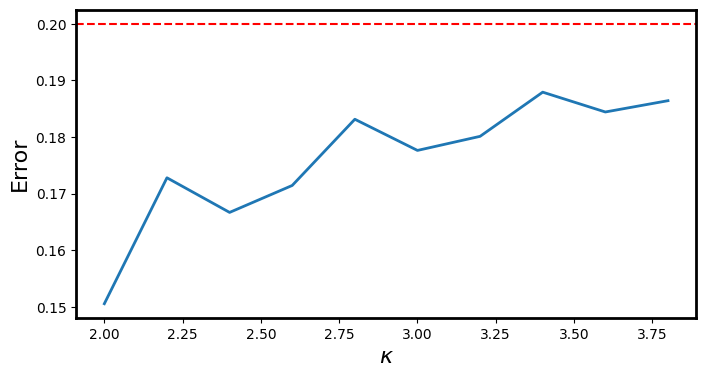

In [115]:
epsilon = 0.2
kappa = np.arange(2,4.0,0.2)
error = np.zeros(kappa.size)
for i,k in enumerate(kappa):
    A,Ainv, Ainv_qsvt, error[i] = find_inverse(kappa = k, epsilon = epsilon, num_qubits = 5, square = False)

# plot the results
plt.plot(kappa,error, linewidth = 2)
plt.xlabel(r'$\kappa$')
plt.ylabel('Error')
plt.axhline(y=epsilon, color='red', linestyle='--')



## Literature
[ [1] J. M. Martyn, Z. M. Rossi, A. K. Tan, and I. L. Chuang, A Grand Unification of Quantum Algorithms, PRX Quantum 2, (2021).](https://arxiv.org/abs/2105.02859)

[[2] A. Gilyén, Y. Su, G. H. Low, and N. Wiebe, Quantum singular value transformation and beyond: Exponential improvements for quantum matrix arithmetics, Proceedings of the Annual ACM Symposium on Theory of Computing 193 (2019)](https://arxiv.org/abs/1806.01838)

[[3] A. Gilyén, Quantum Singular Value Transformation& Its Algorithmic Applications, (2019).](https://dare.uva.nl/search?identifier=20e9733e-6014-402d-afa9-20f3cc4a0568)

[[4] Introduction to Quantum Singular Value Transformation](https://idnm.github.io/blog/posts/quantum_singular_value_transformation_intro/)
